In [ ]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import time
from collections import defaultdict
from itertools import chain
from torch.optim import Optimizer
import warnings

In [ ]:
# print paths of all the files available in the input directory
for dirname, _, filenames in os.walk('/home/sr7729/Data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/home/sr7729/Data/cifar_test_nolabel.pkl
/home/sr7729/Data/cifar-10-python/cifar-10-batches-py/data_batch_1
/home/sr7729/Data/cifar-10-python/cifar-10-batches-py/data_batch_2
/home/sr7729/Data/cifar-10-python/cifar-10-batches-py/batches.meta
/home/sr7729/Data/cifar-10-python/cifar-10-batches-py/test_batch
/home/sr7729/Data/cifar-10-python/cifar-10-batches-py/data_batch_3
/home/sr7729/Data/cifar-10-python/cifar-10-batches-py/data_batch_5
/home/sr7729/Data/cifar-10-python/cifar-10-batches-py/data_batch_4
/home/sr7729/Data/cifar-10-python/cifar-10-batches-py/readme.html


In [ ]:
def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
    return batch

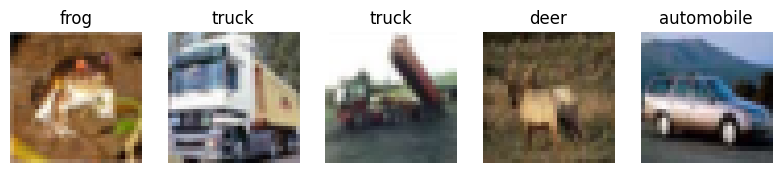

In [ ]:
# Specify the folder where the CIFAR-10 batch files are
cifar10_dir = '/home/sr7729/Data/cifar-10-python/cifar-10-batches-py'

# Load the label names
meta_data_dict = load_cifar_batch(os.path.join(cifar10_dir, 'batches.meta'))
label_names = meta_data_dict[b'label_names']

# Load one batch for demonstration (e.g., data_batch_1)
batch_1_dict = load_cifar_batch(os.path.join(cifar10_dir, 'data_batch_1'))
train_images = batch_1_dict[b'data']
train_labels = batch_1_dict[b'labels']

# Reshape the images
train_images = train_images.reshape((10000, 3, 32, 32)).transpose(0, 2, 3, 1)

# Display the first 5 images and labels
plt.figure(figsize=(20, 4))
for i in range(5):
    plt.subplot(1, 10, i+1)
    plt.imshow(train_images[i])
    plt.title(label_names[train_labels[i]].decode('utf-8'))  # Decoding from bytes to string
    plt.axis('off')
plt.show()

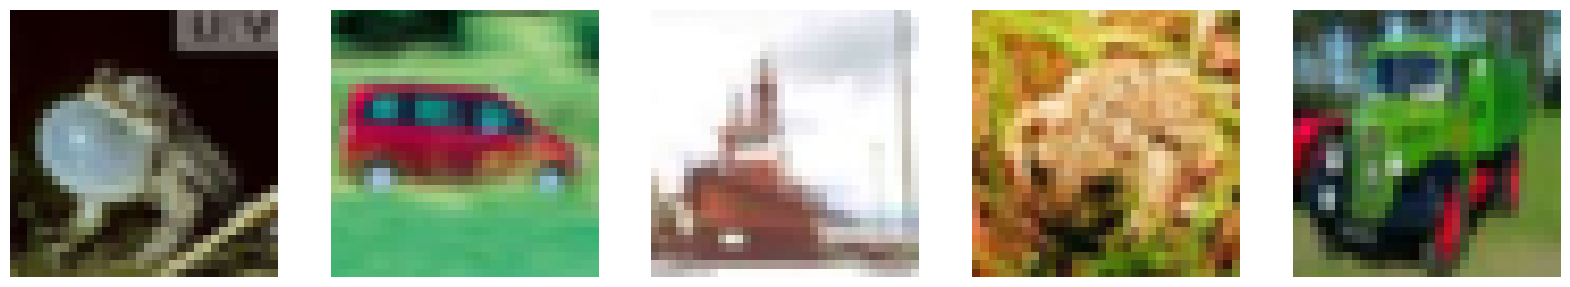

In [ ]:
# Read the test file, it has no labels and needs to be used with our model inference to predict outputs.

# Load the batch
cifar10_batch = load_cifar_batch('/home/sr7729/Data/cifar_test_nolabel.pkl')

# Extract images
images = cifar10_batch[b'data']
# Unlike the train images we don't need to reshape to (number of images, width, height, channels)
# as the test data is already in (N x W x H x C) format

# Display the first 5 images of the test file
plt.figure(figsize=(20, 4))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()


In [ ]:
# Set random seed for reproducibility
torch.manual_seed(40)
if torch.cuda.is_available():
    torch.cuda.manual_seed(40)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Load CIFAR-10 data and prepare train and test data
def load_cifar_data():
    cifar10_dir = '/home/sr7729/Data/cifar-10-python/cifar-10-batches-py'

    # Load training data
    x_train = []
    y_train = []
    for i in range(1, 6):
        batch_file = os.path.join(cifar10_dir, f'data_batch_{i}')
        batch_data = load_cifar_batch(batch_file)
        if i == 1:
            x_train = batch_data[b'data']
            y_train = batch_data[b'labels']
        else:
            x_train = np.vstack((x_train, batch_data[b'data']))
            y_train.extend(batch_data[b'labels'])

    # Reshape and normalize training data
    x_train = x_train.reshape(-1, 3, 32, 32).astype('float32') / 255.0
    y_train = np.array(y_train)

    # Load test data
    test_batch_file = os.path.join(cifar10_dir, 'test_batch')
    test_batch_data = load_cifar_batch(test_batch_file)
    x_test = test_batch_data[b'data'].reshape(-1, 3, 32, 32).astype('float32') / 255.0
    y_test = np.array(test_batch_data[b'labels'])

    # Load meta data (class names)
    meta_data_dict = load_cifar_batch(os.path.join(cifar10_dir, 'batches.meta'))
    class_names = [label.decode('utf-8') for label in meta_data_dict[b'label_names']]

    return (x_train, y_train), (x_test, y_test), class_names

In [ ]:
# Create data loaders with data augmentation (random crops, rotations and horizontal flips)
def get_data_loaders(x_train, y_train, x_test, y_test, batch_size=64):

    # Apply data augmentation transforms to train data
    train_transform = transforms.Compose([
        # First convert from NCHW (3,32,32) to NHWC (32,32,3) for PIL
        transforms.Lambda(lambda x: x.transpose(1, 2, 0)),
        transforms.ToPILImage(),  # Convert to PIL Image
        transforms.RandomCrop(32, padding=4),  # Random crops with padding
        transforms.RandomHorizontalFlip(),     # Random horizontal flips
        transforms.RandomRotation(15),         # Random rotation up to 15 degrees
        transforms.ColorJitter(    # Random color jittering for robustness
            brightness=0.2,
            contrast=0.2,
            saturation=0.2,
            hue=0.1
        ),
        transforms.ToTensor(),  # Convert back to Tensor (normalizes to [0,1])
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value='random')  # Random Erasing
    ])

    # For test data, just ensure it's in the same [0,1] range
    # No augmentation for test data
    test_transform = transforms.Compose([
        # First convert from NCHW (3,32,32) to NHWC (32,32,3) for PIL
        transforms.Lambda(lambda x: x.transpose(1, 2, 0)),
        transforms.ToPILImage(),
        transforms.ToTensor(),  # Just normalize to [0,1], no augmentation
    ])

    class CIFAR10Dataset(Dataset):
        def __init__(self, images, labels, transform=None):
            self.images = images
            self.labels = labels
            self.transform = transform

        def __len__(self):
            return len(self.labels)

        def __getitem__(self, idx):
            image = self.images[idx]  # (3, 32, 32)
            label = self.labels[idx]

            if self.transform:
                image = self.transform(image)

            return image, label

    # Create datasets
    train_dataset = CIFAR10Dataset(x_train, y_train, transform=train_transform)
    test_dataset = CIFAR10Dataset(x_test, y_test, transform=test_transform)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, test_loader

In [ ]:
# Define Bottleneck Residual Block for improved ResNet
class BottleneckBlock(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BottleneckBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.relu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)

        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        # Add residual (skip connection)
        out += identity
        out = self.relu(out)

        return out

In [ ]:
# Define Improved ResNet Architecture
class ImprovedResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10, dropout_rate=0.2):
        super(ImprovedResNet, self).__init__()
        self.in_channels = 32

        # First layer
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

        # Residual layers with increased width
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.dropout1 = nn.Dropout(dropout_rate/2)  # Lighter dropout after early layers
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.dropout2 = nn.Dropout(dropout_rate)  # Lighter dropout
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.dropout3 = nn.Dropout(dropout_rate)  # Regular dropout

        # Global average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # Higher dropout before final classification layer
        self.dropout_final = nn.Dropout(dropout_rate * 1.5)  # Higher dropout
        self.fc = nn.Linear(256 * block.expansion, num_classes)

        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion)
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion

        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.dropout1(x)  # Apply dropout after layer1
        x = self.layer2(x)
        x = self.dropout2(x)  # Apply dropout after layer2
        x = self.layer3(x)
        x = self.dropout3(x)  # Apply dropout after layer3

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout_final(x)  # Apply higher dropout before classification
        x = self.fc(x)

        return x

In [ ]:
import torch
from torch.optim import Optimizer
from collections import defaultdict

class Lookahead(Optimizer):
    def __init__(self, optimizer, k=5, alpha=0.5):
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f"Invalid alpha parameter: {alpha}")
        if not k >= 1:
            raise ValueError(f"Invalid k parameter: {k}")

        self.optimizer = optimizer
        self.k = k
        self.alpha = alpha

        # Expose defaults and param_groups from inner optimizer
        self.defaults = optimizer.defaults
        self.param_groups = optimizer.param_groups

        self.state = defaultdict(dict)
        for group in self.param_groups:
            group["counter"] = 0

    def update(self, group):
        for fast in group["params"]:
            param_state = self.state[fast]
            if "slow_param" not in param_state:
                param_state["slow_param"] = torch.zeros_like(fast.data)
                param_state["slow_param"].copy_(fast.data)
            slow = param_state["slow_param"]
            slow += (fast.data - slow) * self.alpha
            fast.data.copy_(slow)

    def step(self, closure=None):
        loss = self.optimizer.step(closure)
        for group in self.param_groups:
            group["counter"] += 1
            if group["counter"] >= self.k:
                self.update(group)
                group["counter"] = 0
        return loss

    def zero_grad(self, set_to_none=True):
        # Delegate zero_grad to wrapped optimizer
        self.optimizer.zero_grad(set_to_none=set_to_none)

    def state_dict(self):
        fast_state_dict = self.optimizer.state_dict()
        slow_state = {
            (id(k) if isinstance(k, torch.Tensor) else k): v
            for k, v in self.state.items()
        }
        return {
            "fast_state": fast_state_dict["state"],
            "slow_state": slow_state,
            "param_groups": fast_state_dict["param_groups"],
            "k": self.k,
            "alpha": self.alpha,
        }

    def load_state_dict(self, state_dict):
        fast_state_dict = {
            "state": state_dict["fast_state"],
            "param_groups": state_dict["param_groups"],
        }
        slow_state_dict = state_dict["slow_state"]

        # Load states into inner optimizer and Lookahead wrapper
        self.optimizer.load_state_dict(fast_state_dict)
        self.state = defaultdict(dict)

        id_map = {id(p): p for group in self.param_groups for p in group["params"]}

        for key, value in slow_state_dict.items():
            param = id_map[int(key)]
            self.state[param] = value

    def add_param_group(self, param_group):
        param_group["counter"] = 0
        self.optimizer.add_param_group(param_group)


In [ ]:
# Function to count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
# Training function with mixup data augmentation
def train(model, train_loader, optimizer, criterion, device, use_mixup=True, alpha=0.2):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in tqdm(train_loader, desc="Training"):
        inputs, targets = inputs.to(device), targets.to(device)

        # Apply mixup augmentation
        if use_mixup and alpha > 0:
            lam = np.random.beta(alpha, alpha)
            batch_size = inputs.size()[0]
            index = torch.randperm(batch_size).to(device)
            mixed_inputs = lam * inputs + (1 - lam) * inputs[index, :]

            # Forward pass with mixed inputs
            outputs = model(mixed_inputs)

            # Compute mixed loss
            loss = lam * criterion(outputs, targets) + (1 - lam) * criterion(outputs, targets[index])

            # For accuracy calculation, we need to do a separate forward pass with unmixed inputs
            with torch.no_grad():
                unmixed_outputs = model(inputs)
                _, predicted = unmixed_outputs.max(1)
                correct += predicted.eq(targets).sum().item()
        else:
            # Standard forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Accuracy calculation
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        total += targets.size(0)

    return running_loss / len(train_loader), 100. * correct / total

In [ ]:
# Evaluation function
def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Evaluating"):
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Statistics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    return running_loss / len(test_loader), 100. * correct / total

In [ ]:
# load data and start training
(x_train, y_train), (x_test, y_test), class_names = load_cifar_data()
print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")

# load model
# Use bottleneck blocks for higher capacity with similar parameters
# number of blocks per layer is kept as [3, 3, 3]
model = ImprovedResNet(BottleneckBlock, [3, 3, 3], num_classes=10, dropout_rate=0.2).to(device)

# count the number of trainable parameters
num_params = count_parameters(model)
print(f"Number of trainable parameters: {num_params:,}")
print(f"Parameter limit: 5,000,000")

# Make sure we are within our parameter limit
assert num_params < 5000000, "Model has too many parameters!"

# Print model summary
try:
    from torchsummary import summary
    summary(model, (3, 32, 32))
except ImportError:
    print("torchsummary not available. Skipping model summary.")

Training data shape: (50000, 3, 32, 32)
Test data shape: (10000, 3, 32, 32)
Number of trainable parameters: 4,903,082
Parameter limit: 5,000,000
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
         LeakyReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]           2,048
       BatchNorm2d-5           [-1, 64, 32, 32]             128
         LeakyReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
         LeakyReLU-9           [-1, 64, 32, 32]               0
           Conv2d-10          [-1, 256, 32, 32]          16,384
      BatchNorm2d-11          [-1, 256, 32, 32]             512
           Conv2d-12  

In [ ]:
# Create data loaders with augmentation
train_loader, test_loader = get_data_loaders(x_train, y_train, x_test, y_test, batch_size=64)

# Use SGD optimizer with momentum and learning rate scheduling
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=1e-4)
optimizer = Lookahead(optimizer, k=5, alpha=0.5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=400)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

In [ ]:
# Training loop with early stopping
num_epochs = 400
train_losses = []
test_losses = []
train_accs = []
test_accs = []
LRR=[]
best_train_acc = 0.0
best_acc = 0.0
best_model_state = None
patience = 50
patience_counter = 0

print(f"Starting training for {num_epochs} epochs...")
start_time = time.time()

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Train
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)

    # Evaluate
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)

    # Update learning rate
    scheduler.step()

    # Save statistics
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    LRR.append(optimizer.param_groups[0]['lr'])

    # Print statistics
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    print(f"Current LR: {optimizer.param_groups[0]['lr']:.6f}")

    # Save best model
    if test_acc > best_acc:
        best_acc = test_acc
        best_train_acc = train_acc
        best_model_state = model.state_dict().copy()
        print(f"New best train accuracy: {best_train_acc:.2f}%")
        print(f"New best test accuracy: {best_acc:.2f}%")
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"No improvement for {patience_counter} epochs.")

    # Early stopping if the test accuracy does not improve for 50 consecutive epochs
    if patience_counter >= patience:
        print("Early stopping triggered!")
        break

    print("=" * 50)

end_time = time.time()
training_time = end_time - start_time
print(f"Training completed in {training_time/60:.2f} minutes")
print(f"Best train accuracy: {best_train_acc:.2f}%")
print(f"Best test accuracy: {best_acc:.2f}%")

Starting training for 400 epochs...
Epoch 1/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.2215, Train Acc: 24.77%
Test Loss: 1.8246, Test Acc: 38.92%
Current LR: 0.049999
New best train accuracy: 24.77%
New best test accuracy: 38.92%
Epoch 2/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.8794, Train Acc: 40.77%
Test Loss: 1.7015, Test Acc: 45.66%
Current LR: 0.049997
New best train accuracy: 40.77%
New best test accuracy: 45.66%
Epoch 3/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.7271, Train Acc: 50.09%
Test Loss: 1.4154, Test Acc: 58.12%
Current LR: 0.049993
New best train accuracy: 50.09%
New best test accuracy: 58.12%
Epoch 4/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.6451, Train Acc: 55.64%
Test Loss: 1.2938, Test Acc: 65.04%
Current LR: 0.049988
New best train accuracy: 55.64%
New best test accuracy: 65.04%
Epoch 5/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.5971, Train Acc: 59.69%
Test Loss: 1.2512, Test Acc: 67.10%
Current LR: 0.049981
New best train accuracy: 59.69%
New best test accuracy: 67.10%
Epoch 6/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.5511, Train Acc: 62.01%
Test Loss: 1.2465, Test Acc: 68.30%
Current LR: 0.049972
New best train accuracy: 62.01%
New best test accuracy: 68.30%
Epoch 7/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.5041, Train Acc: 64.36%
Test Loss: 1.2263, Test Acc: 69.27%
Current LR: 0.049962
New best train accuracy: 64.36%
New best test accuracy: 69.27%
Epoch 8/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.4643, Train Acc: 66.46%
Test Loss: 1.1548, Test Acc: 72.83%
Current LR: 0.049951
New best train accuracy: 66.46%
New best test accuracy: 72.83%
Epoch 9/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.4432, Train Acc: 68.68%
Test Loss: 1.1303, Test Acc: 73.98%
Current LR: 0.049938
New best train accuracy: 68.68%
New best test accuracy: 73.98%
Epoch 10/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.4012, Train Acc: 70.12%
Test Loss: 1.0409, Test Acc: 77.45%
Current LR: 0.049923
New best train accuracy: 70.12%
New best test accuracy: 77.45%
Epoch 11/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.3888, Train Acc: 71.47%
Test Loss: 1.0276, Test Acc: 77.70%
Current LR: 0.049907
New best train accuracy: 71.47%
New best test accuracy: 77.70%
Epoch 12/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.3660, Train Acc: 72.62%
Test Loss: 1.1031, Test Acc: 75.89%
Current LR: 0.049889
No improvement for 1 epochs.
Epoch 13/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.3511, Train Acc: 73.56%
Test Loss: 0.9791, Test Acc: 80.40%
Current LR: 0.049870
New best train accuracy: 73.56%
New best test accuracy: 80.40%
Epoch 14/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.3401, Train Acc: 74.16%
Test Loss: 0.9817, Test Acc: 80.50%
Current LR: 0.049849
New best train accuracy: 74.16%
New best test accuracy: 80.50%
Epoch 15/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.3228, Train Acc: 74.91%
Test Loss: 0.9413, Test Acc: 82.44%
Current LR: 0.049827
New best train accuracy: 74.91%
New best test accuracy: 82.44%
Epoch 16/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.3059, Train Acc: 75.86%
Test Loss: 0.9529, Test Acc: 81.23%
Current LR: 0.049803
No improvement for 1 epochs.
Epoch 17/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.3176, Train Acc: 76.27%
Test Loss: 0.9718, Test Acc: 80.54%
Current LR: 0.049777
No improvement for 2 epochs.
Epoch 18/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.2902, Train Acc: 76.72%
Test Loss: 0.9196, Test Acc: 82.99%
Current LR: 0.049751
New best train accuracy: 76.72%
New best test accuracy: 82.99%
Epoch 19/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.2810, Train Acc: 77.43%
Test Loss: 0.9224, Test Acc: 82.53%
Current LR: 0.049722
No improvement for 1 epochs.
Epoch 20/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.2671, Train Acc: 77.89%
Test Loss: 0.8826, Test Acc: 84.69%
Current LR: 0.049692
New best train accuracy: 77.89%
New best test accuracy: 84.69%
Epoch 21/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.2560, Train Acc: 78.32%
Test Loss: 0.9553, Test Acc: 81.56%
Current LR: 0.049661
No improvement for 1 epochs.
Epoch 22/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.2759, Train Acc: 78.74%
Test Loss: 0.9376, Test Acc: 82.17%
Current LR: 0.049628
No improvement for 2 epochs.
Epoch 23/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.2372, Train Acc: 79.08%
Test Loss: 0.8646, Test Acc: 85.28%
Current LR: 0.049593
New best train accuracy: 79.08%
New best test accuracy: 85.28%
Epoch 24/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.2582, Train Acc: 79.55%
Test Loss: 0.8675, Test Acc: 85.28%
Current LR: 0.049557
No improvement for 1 epochs.
Epoch 25/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.2306, Train Acc: 80.05%
Test Loss: 0.8526, Test Acc: 85.72%
Current LR: 0.049520
New best train accuracy: 80.05%
New best test accuracy: 85.72%
Epoch 26/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.2361, Train Acc: 80.14%
Test Loss: 0.8585, Test Acc: 85.92%
Current LR: 0.049481
New best train accuracy: 80.14%
New best test accuracy: 85.92%
Epoch 27/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.2048, Train Acc: 80.39%
Test Loss: 0.8878, Test Acc: 84.15%
Current LR: 0.049440
No improvement for 1 epochs.
Epoch 28/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.2130, Train Acc: 80.84%
Test Loss: 0.8377, Test Acc: 86.89%
Current LR: 0.049398
New best train accuracy: 80.84%
New best test accuracy: 86.89%
Epoch 29/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.2115, Train Acc: 81.32%
Test Loss: 0.8629, Test Acc: 85.24%
Current LR: 0.049354
No improvement for 1 epochs.
Epoch 30/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.1958, Train Acc: 81.50%
Test Loss: 0.8372, Test Acc: 87.18%
Current LR: 0.049309
New best train accuracy: 81.50%
New best test accuracy: 87.18%
Epoch 31/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.1864, Train Acc: 81.79%
Test Loss: 0.8305, Test Acc: 87.07%
Current LR: 0.049263
No improvement for 1 epochs.
Epoch 32/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.2102, Train Acc: 82.10%
Test Loss: 0.8635, Test Acc: 85.60%
Current LR: 0.049215
No improvement for 2 epochs.
Epoch 33/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.1810, Train Acc: 82.57%
Test Loss: 0.8214, Test Acc: 87.23%
Current LR: 0.049165
New best train accuracy: 82.57%
New best test accuracy: 87.23%
Epoch 34/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.1824, Train Acc: 82.52%
Test Loss: 0.8504, Test Acc: 85.89%
Current LR: 0.049114
No improvement for 1 epochs.
Epoch 35/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.1787, Train Acc: 82.61%
Test Loss: 0.8061, Test Acc: 87.89%
Current LR: 0.049061
New best train accuracy: 82.61%
New best test accuracy: 87.89%
Epoch 36/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.1718, Train Acc: 83.15%
Test Loss: 0.8284, Test Acc: 86.60%
Current LR: 0.049007
No improvement for 1 epochs.
Epoch 37/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.1690, Train Acc: 83.01%
Test Loss: 0.8692, Test Acc: 84.90%
Current LR: 0.048952
No improvement for 2 epochs.
Epoch 38/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.1808, Train Acc: 83.08%
Test Loss: 0.7947, Test Acc: 88.39%
Current LR: 0.048895
New best train accuracy: 83.08%
New best test accuracy: 88.39%
Epoch 39/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.1635, Train Acc: 83.77%
Test Loss: 0.8127, Test Acc: 87.56%
Current LR: 0.048836
No improvement for 1 epochs.
Epoch 40/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.1602, Train Acc: 83.58%
Test Loss: 0.7873, Test Acc: 88.86%
Current LR: 0.048776
New best train accuracy: 83.58%
New best test accuracy: 88.86%
Epoch 41/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.1751, Train Acc: 83.63%
Test Loss: 0.8059, Test Acc: 87.89%
Current LR: 0.048715
No improvement for 1 epochs.
Epoch 42/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.1632, Train Acc: 84.24%
Test Loss: 0.8138, Test Acc: 87.42%
Current LR: 0.048652
No improvement for 2 epochs.
Epoch 43/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.1331, Train Acc: 84.39%
Test Loss: 0.7792, Test Acc: 88.94%
Current LR: 0.048588
New best train accuracy: 84.39%
New best test accuracy: 88.94%
Epoch 44/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.1514, Train Acc: 84.28%
Test Loss: 0.8146, Test Acc: 87.18%
Current LR: 0.048522
No improvement for 1 epochs.
Epoch 45/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.1579, Train Acc: 84.51%
Test Loss: 0.7643, Test Acc: 89.44%
Current LR: 0.048455
New best train accuracy: 84.51%
New best test accuracy: 89.44%
Epoch 46/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.1432, Train Acc: 84.66%
Test Loss: 0.7984, Test Acc: 87.91%
Current LR: 0.048386
No improvement for 1 epochs.
Epoch 47/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.1246, Train Acc: 84.97%
Test Loss: 0.8859, Test Acc: 84.01%
Current LR: 0.048316
No improvement for 2 epochs.
Epoch 48/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.1386, Train Acc: 85.04%
Test Loss: 0.7736, Test Acc: 89.33%
Current LR: 0.048244
No improvement for 3 epochs.
Epoch 49/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.1201, Train Acc: 85.10%
Test Loss: 0.7931, Test Acc: 88.48%
Current LR: 0.048171
No improvement for 4 epochs.
Epoch 50/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.1432, Train Acc: 85.30%
Test Loss: 0.7631, Test Acc: 89.18%
Current LR: 0.048097
No improvement for 5 epochs.
Epoch 51/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.1217, Train Acc: 85.37%
Test Loss: 0.7841, Test Acc: 88.58%
Current LR: 0.048021
No improvement for 6 epochs.
Epoch 52/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.1087, Train Acc: 85.52%
Test Loss: 0.7783, Test Acc: 89.30%
Current LR: 0.047944
No improvement for 7 epochs.
Epoch 53/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.1180, Train Acc: 85.61%
Test Loss: 0.7648, Test Acc: 89.76%
Current LR: 0.047865
New best train accuracy: 85.61%
New best test accuracy: 89.76%
Epoch 54/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.1266, Train Acc: 85.93%
Test Loss: 0.7834, Test Acc: 88.95%
Current LR: 0.047785
No improvement for 1 epochs.
Epoch 55/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.1010, Train Acc: 85.97%
Test Loss: 0.7523, Test Acc: 90.02%
Current LR: 0.047704
New best train accuracy: 85.97%
New best test accuracy: 90.02%
Epoch 56/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.1120, Train Acc: 86.02%
Test Loss: 0.7692, Test Acc: 89.38%
Current LR: 0.047621
No improvement for 1 epochs.
Epoch 57/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0971, Train Acc: 86.14%
Test Loss: 0.7667, Test Acc: 89.14%
Current LR: 0.047536
No improvement for 2 epochs.
Epoch 58/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.1205, Train Acc: 86.45%
Test Loss: 0.7418, Test Acc: 90.60%
Current LR: 0.047451
New best train accuracy: 86.45%
New best test accuracy: 90.60%
Epoch 59/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.1212, Train Acc: 86.27%
Test Loss: 0.7651, Test Acc: 89.54%
Current LR: 0.047364
No improvement for 1 epochs.
Epoch 60/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0935, Train Acc: 86.36%
Test Loss: 0.7354, Test Acc: 90.62%
Current LR: 0.047275
New best train accuracy: 86.36%
New best test accuracy: 90.62%
Epoch 61/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0946, Train Acc: 86.53%
Test Loss: 0.7574, Test Acc: 89.55%
Current LR: 0.047185
No improvement for 1 epochs.
Epoch 62/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.1394, Train Acc: 86.63%
Test Loss: 0.8251, Test Acc: 87.11%
Current LR: 0.047094
No improvement for 2 epochs.
Epoch 63/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0889, Train Acc: 86.79%
Test Loss: 0.7365, Test Acc: 90.73%
Current LR: 0.047002
New best train accuracy: 86.79%
New best test accuracy: 90.73%
Epoch 64/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0874, Train Acc: 86.78%
Test Loss: 0.7517, Test Acc: 90.06%
Current LR: 0.046908
No improvement for 1 epochs.
Epoch 65/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0958, Train Acc: 87.05%
Test Loss: 0.7278, Test Acc: 91.04%
Current LR: 0.046812
New best train accuracy: 87.05%
New best test accuracy: 91.04%
Epoch 66/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.1012, Train Acc: 87.11%
Test Loss: 0.7372, Test Acc: 90.91%
Current LR: 0.046716
No improvement for 1 epochs.
Epoch 67/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0811, Train Acc: 86.89%
Test Loss: 0.7544, Test Acc: 89.72%
Current LR: 0.046618
No improvement for 2 epochs.
Epoch 68/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.1060, Train Acc: 87.17%
Test Loss: 0.7358, Test Acc: 90.81%
Current LR: 0.046519
No improvement for 3 epochs.
Epoch 69/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0979, Train Acc: 87.51%
Test Loss: 0.7463, Test Acc: 90.55%
Current LR: 0.046418
No improvement for 4 epochs.
Epoch 70/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0888, Train Acc: 87.26%
Test Loss: 0.7297, Test Acc: 90.96%
Current LR: 0.046316
No improvement for 5 epochs.
Epoch 71/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0894, Train Acc: 87.67%
Test Loss: 0.7468, Test Acc: 90.56%
Current LR: 0.046213
No improvement for 6 epochs.
Epoch 72/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0655, Train Acc: 87.44%
Test Loss: 0.7341, Test Acc: 90.78%
Current LR: 0.046108
No improvement for 7 epochs.
Epoch 73/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0774, Train Acc: 87.60%
Test Loss: 0.7369, Test Acc: 90.89%
Current LR: 0.046002
No improvement for 8 epochs.
Epoch 74/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0892, Train Acc: 87.66%
Test Loss: 0.7513, Test Acc: 90.36%
Current LR: 0.045895
No improvement for 9 epochs.
Epoch 75/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0798, Train Acc: 87.82%
Test Loss: 0.7230, Test Acc: 91.57%
Current LR: 0.045787
New best train accuracy: 87.82%
New best test accuracy: 91.57%
Epoch 76/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0798, Train Acc: 87.77%
Test Loss: 0.7266, Test Acc: 91.41%
Current LR: 0.045677
No improvement for 1 epochs.
Epoch 77/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0630, Train Acc: 87.95%
Test Loss: 0.7330, Test Acc: 91.00%
Current LR: 0.045566
No improvement for 2 epochs.
Epoch 78/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0868, Train Acc: 87.93%
Test Loss: 0.7457, Test Acc: 90.77%
Current LR: 0.045454
No improvement for 3 epochs.
Epoch 79/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0790, Train Acc: 88.23%
Test Loss: 0.7947, Test Acc: 88.30%
Current LR: 0.045340
No improvement for 4 epochs.
Epoch 80/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0561, Train Acc: 88.16%
Test Loss: 0.7339, Test Acc: 90.93%
Current LR: 0.045225
No improvement for 5 epochs.
Epoch 81/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0818, Train Acc: 88.24%
Test Loss: 0.7187, Test Acc: 91.48%
Current LR: 0.045109
No improvement for 6 epochs.
Epoch 82/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0679, Train Acc: 88.30%
Test Loss: 0.7255, Test Acc: 91.10%
Current LR: 0.044992
No improvement for 7 epochs.
Epoch 83/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0699, Train Acc: 88.31%
Test Loss: 0.7225, Test Acc: 91.25%
Current LR: 0.044874
No improvement for 8 epochs.
Epoch 84/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0891, Train Acc: 88.35%
Test Loss: 0.7394, Test Acc: 90.71%
Current LR: 0.044754
No improvement for 9 epochs.
Epoch 85/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0552, Train Acc: 88.66%
Test Loss: 0.7109, Test Acc: 91.95%
Current LR: 0.044633
New best train accuracy: 88.66%
New best test accuracy: 91.95%
Epoch 86/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0614, Train Acc: 88.44%
Test Loss: 0.7160, Test Acc: 91.73%
Current LR: 0.044511
No improvement for 1 epochs.
Epoch 87/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0603, Train Acc: 88.56%
Test Loss: 0.7578, Test Acc: 90.02%
Current LR: 0.044387
No improvement for 2 epochs.
Epoch 88/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0817, Train Acc: 88.86%
Test Loss: 0.7031, Test Acc: 92.26%
Current LR: 0.044263
New best train accuracy: 88.86%
New best test accuracy: 92.26%
Epoch 89/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0687, Train Acc: 89.05%
Test Loss: 0.7447, Test Acc: 90.23%
Current LR: 0.044137
No improvement for 1 epochs.
Epoch 90/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0540, Train Acc: 89.00%
Test Loss: 0.6981, Test Acc: 92.06%
Current LR: 0.044010
No improvement for 2 epochs.
Epoch 91/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0462, Train Acc: 88.74%
Test Loss: 0.7037, Test Acc: 92.21%
Current LR: 0.043882
No improvement for 3 epochs.
Epoch 92/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0664, Train Acc: 88.74%
Test Loss: 0.7373, Test Acc: 91.19%
Current LR: 0.043753
No improvement for 4 epochs.
Epoch 93/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0545, Train Acc: 89.10%
Test Loss: 0.7052, Test Acc: 92.09%
Current LR: 0.043622
No improvement for 5 epochs.
Epoch 94/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0637, Train Acc: 89.09%
Test Loss: 0.7248, Test Acc: 91.36%
Current LR: 0.043491
No improvement for 6 epochs.
Epoch 95/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0454, Train Acc: 89.01%
Test Loss: 0.6983, Test Acc: 92.49%
Current LR: 0.043358
New best train accuracy: 89.01%
New best test accuracy: 92.49%
Epoch 96/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0156, Train Acc: 89.18%
Test Loss: 0.7267, Test Acc: 91.32%
Current LR: 0.043224
No improvement for 1 epochs.
Epoch 97/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0652, Train Acc: 89.01%
Test Loss: 0.7252, Test Acc: 91.21%
Current LR: 0.043089
No improvement for 2 epochs.
Epoch 98/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0316, Train Acc: 89.08%
Test Loss: 0.6904, Test Acc: 92.68%
Current LR: 0.042953
New best train accuracy: 89.08%
New best test accuracy: 92.68%
Epoch 99/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0486, Train Acc: 89.51%
Test Loss: 0.7693, Test Acc: 89.58%
Current LR: 0.042816
No improvement for 1 epochs.
Epoch 100/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0485, Train Acc: 89.23%
Test Loss: 0.6972, Test Acc: 92.43%
Current LR: 0.042678
No improvement for 2 epochs.
Epoch 101/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0458, Train Acc: 89.23%
Test Loss: 0.6927, Test Acc: 92.73%
Current LR: 0.042538
New best train accuracy: 89.23%
New best test accuracy: 92.73%
Epoch 102/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0528, Train Acc: 89.73%
Test Loss: 0.7478, Test Acc: 91.15%
Current LR: 0.042398
No improvement for 1 epochs.
Epoch 103/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0452, Train Acc: 89.63%
Test Loss: 0.7013, Test Acc: 92.31%
Current LR: 0.042256
No improvement for 2 epochs.
Epoch 104/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0378, Train Acc: 89.54%
Test Loss: 0.7141, Test Acc: 91.94%
Current LR: 0.042114
No improvement for 3 epochs.
Epoch 105/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0279, Train Acc: 89.72%
Test Loss: 0.6958, Test Acc: 92.59%
Current LR: 0.041970
No improvement for 4 epochs.
Epoch 106/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0421, Train Acc: 89.63%
Test Loss: 0.7209, Test Acc: 91.46%
Current LR: 0.041825
No improvement for 5 epochs.
Epoch 107/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0314, Train Acc: 89.75%
Test Loss: 0.7388, Test Acc: 90.72%
Current LR: 0.041680
No improvement for 6 epochs.
Epoch 108/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0519, Train Acc: 89.67%
Test Loss: 0.7129, Test Acc: 92.33%
Current LR: 0.041533
No improvement for 7 epochs.
Epoch 109/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0249, Train Acc: 89.84%
Test Loss: 0.7159, Test Acc: 92.05%
Current LR: 0.041385
No improvement for 8 epochs.
Epoch 110/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0502, Train Acc: 89.74%
Test Loss: 0.7043, Test Acc: 92.44%
Current LR: 0.041236
No improvement for 9 epochs.
Epoch 111/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0528, Train Acc: 90.08%
Test Loss: 0.6936, Test Acc: 92.69%
Current LR: 0.041086
No improvement for 10 epochs.
Epoch 112/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0423, Train Acc: 90.06%
Test Loss: 0.7248, Test Acc: 91.47%
Current LR: 0.040936
No improvement for 11 epochs.
Epoch 113/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0398, Train Acc: 89.80%
Test Loss: 0.6925, Test Acc: 92.65%
Current LR: 0.040784
No improvement for 12 epochs.
Epoch 114/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0475, Train Acc: 90.00%
Test Loss: 0.7244, Test Acc: 91.19%
Current LR: 0.040631
No improvement for 13 epochs.
Epoch 115/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0360, Train Acc: 90.01%
Test Loss: 0.6942, Test Acc: 92.74%
Current LR: 0.040477
New best train accuracy: 90.01%
New best test accuracy: 92.74%
Epoch 116/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0562, Train Acc: 90.16%
Test Loss: 0.7033, Test Acc: 92.71%
Current LR: 0.040323
No improvement for 1 epochs.
Epoch 117/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0514, Train Acc: 90.12%
Test Loss: 0.7141, Test Acc: 91.62%
Current LR: 0.040167
No improvement for 2 epochs.
Epoch 118/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0316, Train Acc: 90.18%
Test Loss: 0.6907, Test Acc: 93.11%
Current LR: 0.040011
New best train accuracy: 90.18%
New best test accuracy: 93.11%
Epoch 119/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0264, Train Acc: 90.28%
Test Loss: 0.7460, Test Acc: 90.34%
Current LR: 0.039853
No improvement for 1 epochs.
Epoch 120/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9884, Train Acc: 90.24%
Test Loss: 0.6819, Test Acc: 93.19%
Current LR: 0.039695
New best train accuracy: 90.24%
New best test accuracy: 93.19%
Epoch 121/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0364, Train Acc: 90.36%
Test Loss: 0.6945, Test Acc: 92.56%
Current LR: 0.039535
No improvement for 1 epochs.
Epoch 122/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0101, Train Acc: 90.39%
Test Loss: 0.7375, Test Acc: 90.86%
Current LR: 0.039375
No improvement for 2 epochs.
Epoch 123/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0547, Train Acc: 90.32%
Test Loss: 0.6873, Test Acc: 92.95%
Current LR: 0.039214
No improvement for 3 epochs.
Epoch 124/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0104, Train Acc: 90.66%
Test Loss: 0.7063, Test Acc: 92.47%
Current LR: 0.039052
No improvement for 4 epochs.
Epoch 125/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0276, Train Acc: 90.51%
Test Loss: 0.6796, Test Acc: 93.01%
Current LR: 0.038889
No improvement for 5 epochs.
Epoch 126/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0203, Train Acc: 90.26%
Test Loss: 0.7009, Test Acc: 92.51%
Current LR: 0.038726
No improvement for 6 epochs.
Epoch 127/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0261, Train Acc: 90.69%
Test Loss: 0.7136, Test Acc: 91.78%
Current LR: 0.038561
No improvement for 7 epochs.
Epoch 128/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0097, Train Acc: 90.69%
Test Loss: 0.6915, Test Acc: 92.80%
Current LR: 0.038396
No improvement for 8 epochs.
Epoch 129/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0143, Train Acc: 90.57%
Test Loss: 0.7053, Test Acc: 92.03%
Current LR: 0.038229
No improvement for 9 epochs.
Epoch 130/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0010, Train Acc: 90.53%
Test Loss: 0.6937, Test Acc: 92.81%
Current LR: 0.038062
No improvement for 10 epochs.
Epoch 131/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0005, Train Acc: 90.80%
Test Loss: 0.6990, Test Acc: 92.44%
Current LR: 0.037895
No improvement for 11 epochs.
Epoch 132/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0186, Train Acc: 90.87%
Test Loss: 0.6979, Test Acc: 92.39%
Current LR: 0.037726
No improvement for 12 epochs.
Epoch 133/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0058, Train Acc: 90.93%
Test Loss: 0.6822, Test Acc: 93.33%
Current LR: 0.037557
New best train accuracy: 90.93%
New best test accuracy: 93.33%
Epoch 134/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0227, Train Acc: 90.88%
Test Loss: 0.6928, Test Acc: 92.51%
Current LR: 0.037386
No improvement for 1 epochs.
Epoch 135/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0116, Train Acc: 91.28%
Test Loss: 0.6719, Test Acc: 93.35%
Current LR: 0.037216
New best train accuracy: 91.28%
New best test accuracy: 93.35%
Epoch 136/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0148, Train Acc: 91.31%
Test Loss: 0.6964, Test Acc: 92.99%
Current LR: 0.037044
No improvement for 1 epochs.
Epoch 137/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0107, Train Acc: 91.28%
Test Loss: 0.7025, Test Acc: 92.33%
Current LR: 0.036871
No improvement for 2 epochs.
Epoch 138/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0224, Train Acc: 91.34%
Test Loss: 0.6779, Test Acc: 93.17%
Current LR: 0.036698
No improvement for 3 epochs.
Epoch 139/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0260, Train Acc: 91.00%
Test Loss: 0.6997, Test Acc: 91.95%
Current LR: 0.036524
No improvement for 4 epochs.
Epoch 140/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0058, Train Acc: 91.19%
Test Loss: 0.6681, Test Acc: 93.68%
Current LR: 0.036350
New best train accuracy: 91.19%
New best test accuracy: 93.68%
Epoch 141/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0235, Train Acc: 91.24%
Test Loss: 0.6988, Test Acc: 92.15%
Current LR: 0.036174
No improvement for 1 epochs.
Epoch 142/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9979, Train Acc: 91.18%
Test Loss: 0.7082, Test Acc: 92.00%
Current LR: 0.035998
No improvement for 2 epochs.
Epoch 143/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0091, Train Acc: 91.53%
Test Loss: 0.6721, Test Acc: 93.60%
Current LR: 0.035822
No improvement for 3 epochs.
Epoch 144/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0192, Train Acc: 91.24%
Test Loss: 0.7007, Test Acc: 92.64%
Current LR: 0.035644
No improvement for 4 epochs.
Epoch 145/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0164, Train Acc: 91.56%
Test Loss: 0.6832, Test Acc: 93.33%
Current LR: 0.035466
No improvement for 5 epochs.
Epoch 146/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0266, Train Acc: 91.43%
Test Loss: 0.6870, Test Acc: 93.22%
Current LR: 0.035288
No improvement for 6 epochs.
Epoch 147/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9780, Train Acc: 91.35%
Test Loss: 0.7010, Test Acc: 92.16%
Current LR: 0.035109
No improvement for 7 epochs.
Epoch 148/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0010, Train Acc: 91.28%
Test Loss: 0.6836, Test Acc: 93.41%
Current LR: 0.034929
No improvement for 8 epochs.
Epoch 149/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9939, Train Acc: 91.66%
Test Loss: 0.6802, Test Acc: 93.26%
Current LR: 0.034748
No improvement for 9 epochs.
Epoch 150/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9982, Train Acc: 91.44%
Test Loss: 0.6691, Test Acc: 94.08%
Current LR: 0.034567
New best train accuracy: 91.44%
New best test accuracy: 94.08%
Epoch 151/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9936, Train Acc: 91.66%
Test Loss: 0.6892, Test Acc: 92.70%
Current LR: 0.034385
No improvement for 1 epochs.
Epoch 152/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0261, Train Acc: 91.72%
Test Loss: 0.7123, Test Acc: 91.82%
Current LR: 0.034203
No improvement for 2 epochs.
Epoch 153/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9960, Train Acc: 91.77%
Test Loss: 0.6737, Test Acc: 93.39%
Current LR: 0.034020
No improvement for 3 epochs.
Epoch 154/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9881, Train Acc: 91.93%
Test Loss: 0.6713, Test Acc: 93.78%
Current LR: 0.033837
No improvement for 4 epochs.
Epoch 155/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0153, Train Acc: 91.79%
Test Loss: 0.6781, Test Acc: 93.53%
Current LR: 0.033653
No improvement for 5 epochs.
Epoch 156/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9757, Train Acc: 91.87%
Test Loss: 0.6742, Test Acc: 93.34%
Current LR: 0.033468
No improvement for 6 epochs.
Epoch 157/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0011, Train Acc: 92.04%
Test Loss: 0.6850, Test Acc: 92.99%
Current LR: 0.033283
No improvement for 7 epochs.
Epoch 158/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9925, Train Acc: 91.77%
Test Loss: 0.6686, Test Acc: 93.67%
Current LR: 0.033098
No improvement for 8 epochs.
Epoch 159/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0084, Train Acc: 91.95%
Test Loss: 0.6926, Test Acc: 92.54%
Current LR: 0.032912
No improvement for 9 epochs.
Epoch 160/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9788, Train Acc: 91.98%
Test Loss: 0.6564, Test Acc: 94.07%
Current LR: 0.032725
No improvement for 10 epochs.
Epoch 161/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0068, Train Acc: 91.74%
Test Loss: 0.6787, Test Acc: 93.75%
Current LR: 0.032538
No improvement for 11 epochs.
Epoch 162/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0063, Train Acc: 91.97%
Test Loss: 0.6967, Test Acc: 92.68%
Current LR: 0.032351
No improvement for 12 epochs.
Epoch 163/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9830, Train Acc: 92.09%
Test Loss: 0.6813, Test Acc: 93.17%
Current LR: 0.032163
No improvement for 13 epochs.
Epoch 164/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0028, Train Acc: 92.04%
Test Loss: 0.6737, Test Acc: 93.23%
Current LR: 0.031975
No improvement for 14 epochs.
Epoch 165/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9491, Train Acc: 92.00%
Test Loss: 0.6631, Test Acc: 93.70%
Current LR: 0.031786
No improvement for 15 epochs.
Epoch 166/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0063, Train Acc: 92.19%
Test Loss: 0.6642, Test Acc: 94.10%
Current LR: 0.031597
New best train accuracy: 92.19%
New best test accuracy: 94.10%
Epoch 167/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0026, Train Acc: 92.29%
Test Loss: 0.7277, Test Acc: 91.37%
Current LR: 0.031407
No improvement for 1 epochs.
Epoch 168/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9956, Train Acc: 92.34%
Test Loss: 0.6724, Test Acc: 93.30%
Current LR: 0.031217
No improvement for 2 epochs.
Epoch 169/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0036, Train Acc: 92.53%
Test Loss: 0.6683, Test Acc: 93.55%
Current LR: 0.031027
No improvement for 3 epochs.
Epoch 170/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9905, Train Acc: 92.40%
Test Loss: 0.6608, Test Acc: 93.92%
Current LR: 0.030836
No improvement for 4 epochs.
Epoch 171/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9814, Train Acc: 92.57%
Test Loss: 0.6701, Test Acc: 93.41%
Current LR: 0.030645
No improvement for 5 epochs.
Epoch 172/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9789, Train Acc: 92.26%
Test Loss: 0.6756, Test Acc: 93.36%
Current LR: 0.030454
No improvement for 6 epochs.
Epoch 173/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9995, Train Acc: 92.56%
Test Loss: 0.6636, Test Acc: 93.77%
Current LR: 0.030262
No improvement for 7 epochs.
Epoch 174/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9837, Train Acc: 92.41%
Test Loss: 0.6903, Test Acc: 92.82%
Current LR: 0.030070
No improvement for 8 epochs.
Epoch 175/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9900, Train Acc: 92.41%
Test Loss: 0.6590, Test Acc: 94.25%
Current LR: 0.029877
New best train accuracy: 92.41%
New best test accuracy: 94.25%
Epoch 176/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0006, Train Acc: 92.44%
Test Loss: 0.6664, Test Acc: 93.63%
Current LR: 0.029685
No improvement for 1 epochs.
Epoch 177/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9990, Train Acc: 92.60%
Test Loss: 0.6771, Test Acc: 93.46%
Current LR: 0.029492
No improvement for 2 epochs.
Epoch 178/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9631, Train Acc: 92.89%
Test Loss: 0.6568, Test Acc: 94.33%
Current LR: 0.029298
New best train accuracy: 92.89%
New best test accuracy: 94.33%
Epoch 179/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9635, Train Acc: 92.66%
Test Loss: 0.6729, Test Acc: 93.03%
Current LR: 0.029105
No improvement for 1 epochs.
Epoch 180/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.0053, Train Acc: 92.74%
Test Loss: 0.6564, Test Acc: 94.16%
Current LR: 0.028911
No improvement for 2 epochs.
Epoch 181/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9678, Train Acc: 92.93%
Test Loss: 0.6603, Test Acc: 94.08%
Current LR: 0.028717
No improvement for 3 epochs.
Epoch 182/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9536, Train Acc: 92.70%
Test Loss: 0.6600, Test Acc: 94.30%
Current LR: 0.028523
No improvement for 4 epochs.
Epoch 183/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9845, Train Acc: 92.88%
Test Loss: 0.6576, Test Acc: 94.04%
Current LR: 0.028328
No improvement for 5 epochs.
Epoch 184/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9728, Train Acc: 92.93%
Test Loss: 0.6770, Test Acc: 93.48%
Current LR: 0.028133
No improvement for 6 epochs.
Epoch 185/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9846, Train Acc: 93.00%
Test Loss: 0.6532, Test Acc: 94.39%
Current LR: 0.027938
New best train accuracy: 93.00%
New best test accuracy: 94.39%
Epoch 186/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9887, Train Acc: 92.88%
Test Loss: 0.6690, Test Acc: 93.75%
Current LR: 0.027743
No improvement for 1 epochs.
Epoch 187/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9704, Train Acc: 92.89%
Test Loss: 0.6755, Test Acc: 93.24%
Current LR: 0.027548
No improvement for 2 epochs.
Epoch 188/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9657, Train Acc: 93.06%
Test Loss: 0.6673, Test Acc: 93.37%
Current LR: 0.027353
No improvement for 3 epochs.
Epoch 189/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9624, Train Acc: 92.96%
Test Loss: 0.6648, Test Acc: 93.88%
Current LR: 0.027157
No improvement for 4 epochs.
Epoch 190/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9815, Train Acc: 93.21%
Test Loss: 0.6611, Test Acc: 94.18%
Current LR: 0.026961
No improvement for 5 epochs.
Epoch 191/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9597, Train Acc: 93.04%
Test Loss: 0.6743, Test Acc: 93.63%
Current LR: 0.026766
No improvement for 6 epochs.
Epoch 192/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9619, Train Acc: 93.22%
Test Loss: 0.6878, Test Acc: 93.08%
Current LR: 0.026570
No improvement for 7 epochs.
Epoch 193/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9800, Train Acc: 93.18%
Test Loss: 0.6832, Test Acc: 93.91%
Current LR: 0.026374
No improvement for 8 epochs.
Epoch 194/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9962, Train Acc: 93.29%
Test Loss: 0.6725, Test Acc: 94.27%
Current LR: 0.026178
No improvement for 9 epochs.
Epoch 195/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9544, Train Acc: 93.34%
Test Loss: 0.6540, Test Acc: 94.06%
Current LR: 0.025981
No improvement for 10 epochs.
Epoch 196/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9686, Train Acc: 93.38%
Test Loss: 0.6601, Test Acc: 94.40%
Current LR: 0.025785
New best train accuracy: 93.38%
New best test accuracy: 94.40%
Epoch 197/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9573, Train Acc: 93.27%
Test Loss: 0.7240, Test Acc: 91.27%
Current LR: 0.025589
No improvement for 1 epochs.
Epoch 198/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9677, Train Acc: 93.34%
Test Loss: 0.6606, Test Acc: 94.02%
Current LR: 0.025393
No improvement for 2 epochs.
Epoch 199/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9672, Train Acc: 93.64%
Test Loss: 0.6789, Test Acc: 93.24%
Current LR: 0.025196
No improvement for 3 epochs.
Epoch 200/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9693, Train Acc: 93.51%
Test Loss: 0.6496, Test Acc: 94.38%
Current LR: 0.025000
No improvement for 4 epochs.
Epoch 201/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9636, Train Acc: 93.73%
Test Loss: 0.6457, Test Acc: 94.63%
Current LR: 0.024804
New best train accuracy: 93.73%
New best test accuracy: 94.63%
Epoch 202/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9593, Train Acc: 93.64%
Test Loss: 0.6719, Test Acc: 93.63%
Current LR: 0.024607
No improvement for 1 epochs.
Epoch 203/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9432, Train Acc: 93.62%
Test Loss: 0.6505, Test Acc: 94.31%
Current LR: 0.024411
No improvement for 2 epochs.
Epoch 204/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9487, Train Acc: 93.72%
Test Loss: 0.6600, Test Acc: 93.89%
Current LR: 0.024215
No improvement for 3 epochs.
Epoch 205/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9633, Train Acc: 93.58%
Test Loss: 0.6419, Test Acc: 94.74%
Current LR: 0.024019
New best train accuracy: 93.58%
New best test accuracy: 94.74%
Epoch 206/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9427, Train Acc: 93.64%
Test Loss: 0.6682, Test Acc: 93.61%
Current LR: 0.023822
No improvement for 1 epochs.
Epoch 207/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9837, Train Acc: 93.82%
Test Loss: 0.6579, Test Acc: 93.90%
Current LR: 0.023626
No improvement for 2 epochs.
Epoch 208/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9562, Train Acc: 93.96%
Test Loss: 0.6609, Test Acc: 94.25%
Current LR: 0.023430
No improvement for 3 epochs.
Epoch 209/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9453, Train Acc: 93.77%
Test Loss: 0.6539, Test Acc: 94.22%
Current LR: 0.023234
No improvement for 4 epochs.
Epoch 210/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9814, Train Acc: 93.88%
Test Loss: 0.6501, Test Acc: 94.38%
Current LR: 0.023039
No improvement for 5 epochs.
Epoch 211/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9432, Train Acc: 93.79%
Test Loss: 0.6556, Test Acc: 94.29%
Current LR: 0.022843
No improvement for 6 epochs.
Epoch 212/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9520, Train Acc: 94.05%
Test Loss: 0.6693, Test Acc: 93.66%
Current LR: 0.022647
No improvement for 7 epochs.
Epoch 213/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9391, Train Acc: 93.96%
Test Loss: 0.6737, Test Acc: 93.76%
Current LR: 0.022452
No improvement for 8 epochs.
Epoch 214/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9527, Train Acc: 93.99%
Test Loss: 0.6621, Test Acc: 94.66%
Current LR: 0.022257
No improvement for 9 epochs.
Epoch 215/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9240, Train Acc: 94.10%
Test Loss: 0.6468, Test Acc: 94.44%
Current LR: 0.022062
No improvement for 10 epochs.
Epoch 216/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9489, Train Acc: 94.09%
Test Loss: 0.6470, Test Acc: 94.71%
Current LR: 0.021867
No improvement for 11 epochs.
Epoch 217/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9475, Train Acc: 94.31%
Test Loss: 0.6595, Test Acc: 93.99%
Current LR: 0.021672
No improvement for 12 epochs.
Epoch 218/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9440, Train Acc: 94.33%
Test Loss: 0.6410, Test Acc: 94.75%
Current LR: 0.021477
New best train accuracy: 94.33%
New best test accuracy: 94.75%
Epoch 219/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9441, Train Acc: 94.37%
Test Loss: 0.6539, Test Acc: 94.05%
Current LR: 0.021283
No improvement for 1 epochs.
Epoch 220/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9247, Train Acc: 94.14%
Test Loss: 0.6459, Test Acc: 94.79%
Current LR: 0.021089
New best train accuracy: 94.14%
New best test accuracy: 94.79%
Epoch 221/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9295, Train Acc: 94.39%
Test Loss: 0.6474, Test Acc: 94.37%
Current LR: 0.020895
No improvement for 1 epochs.
Epoch 222/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9440, Train Acc: 94.32%
Test Loss: 0.6495, Test Acc: 94.37%
Current LR: 0.020702
No improvement for 2 epochs.
Epoch 223/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9408, Train Acc: 94.35%
Test Loss: 0.6541, Test Acc: 94.53%
Current LR: 0.020508
No improvement for 3 epochs.
Epoch 224/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9559, Train Acc: 94.37%
Test Loss: 0.6509, Test Acc: 94.39%
Current LR: 0.020315
No improvement for 4 epochs.
Epoch 225/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9469, Train Acc: 94.39%
Test Loss: 0.6383, Test Acc: 94.65%
Current LR: 0.020123
No improvement for 5 epochs.
Epoch 226/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9411, Train Acc: 94.42%
Test Loss: 0.6379, Test Acc: 94.73%
Current LR: 0.019930
No improvement for 6 epochs.
Epoch 227/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9434, Train Acc: 94.51%
Test Loss: 0.6480, Test Acc: 94.57%
Current LR: 0.019738
No improvement for 7 epochs.
Epoch 228/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9229, Train Acc: 94.49%
Test Loss: 0.6428, Test Acc: 94.70%
Current LR: 0.019546
No improvement for 8 epochs.
Epoch 229/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9181, Train Acc: 94.45%
Test Loss: 0.6504, Test Acc: 94.43%
Current LR: 0.019355
No improvement for 9 epochs.
Epoch 230/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9594, Train Acc: 94.62%
Test Loss: 0.6475, Test Acc: 94.74%
Current LR: 0.019164
No improvement for 10 epochs.
Epoch 231/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9304, Train Acc: 94.63%
Test Loss: 0.6488, Test Acc: 94.59%
Current LR: 0.018973
No improvement for 11 epochs.
Epoch 232/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9362, Train Acc: 94.86%
Test Loss: 0.6475, Test Acc: 94.31%
Current LR: 0.018783
No improvement for 12 epochs.
Epoch 233/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9448, Train Acc: 94.73%
Test Loss: 0.6357, Test Acc: 94.81%
Current LR: 0.018593
New best train accuracy: 94.73%
New best test accuracy: 94.81%
Epoch 234/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9292, Train Acc: 94.63%
Test Loss: 0.6460, Test Acc: 94.63%
Current LR: 0.018403
No improvement for 1 epochs.
Epoch 235/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9314, Train Acc: 94.82%
Test Loss: 0.6419, Test Acc: 95.08%
Current LR: 0.018214
New best train accuracy: 94.82%
New best test accuracy: 95.08%
Epoch 236/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9197, Train Acc: 95.12%
Test Loss: 0.6400, Test Acc: 94.89%
Current LR: 0.018025
No improvement for 1 epochs.
Epoch 237/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9431, Train Acc: 94.95%
Test Loss: 0.6420, Test Acc: 94.70%
Current LR: 0.017837
No improvement for 2 epochs.
Epoch 238/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9570, Train Acc: 95.07%
Test Loss: 0.6306, Test Acc: 95.19%
Current LR: 0.017649
New best train accuracy: 95.07%
New best test accuracy: 95.19%
Epoch 239/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9392, Train Acc: 94.90%
Test Loss: 0.6460, Test Acc: 94.43%
Current LR: 0.017462
No improvement for 1 epochs.
Epoch 240/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9419, Train Acc: 94.99%
Test Loss: 0.6496, Test Acc: 94.80%
Current LR: 0.017275
No improvement for 2 epochs.
Epoch 241/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9373, Train Acc: 95.13%
Test Loss: 0.6456, Test Acc: 94.86%
Current LR: 0.017088
No improvement for 3 epochs.
Epoch 242/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9126, Train Acc: 94.89%
Test Loss: 0.6611, Test Acc: 93.99%
Current LR: 0.016902
No improvement for 4 epochs.
Epoch 243/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9301, Train Acc: 95.00%
Test Loss: 0.6381, Test Acc: 95.08%
Current LR: 0.016717
No improvement for 5 epochs.
Epoch 244/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9171, Train Acc: 95.17%
Test Loss: 0.6453, Test Acc: 94.47%
Current LR: 0.016532
No improvement for 6 epochs.
Epoch 245/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9228, Train Acc: 95.24%
Test Loss: 0.6361, Test Acc: 94.86%
Current LR: 0.016347
No improvement for 7 epochs.
Epoch 246/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9097, Train Acc: 95.18%
Test Loss: 0.6320, Test Acc: 95.14%
Current LR: 0.016163
No improvement for 8 epochs.
Epoch 247/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9301, Train Acc: 95.23%
Test Loss: 0.6517, Test Acc: 94.53%
Current LR: 0.015980
No improvement for 9 epochs.
Epoch 248/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9214, Train Acc: 95.44%
Test Loss: 0.6379, Test Acc: 94.99%
Current LR: 0.015797
No improvement for 10 epochs.
Epoch 249/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9402, Train Acc: 95.35%
Test Loss: 0.6299, Test Acc: 94.90%
Current LR: 0.015615
No improvement for 11 epochs.
Epoch 250/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9047, Train Acc: 95.50%
Test Loss: 0.6342, Test Acc: 95.09%
Current LR: 0.015433
No improvement for 12 epochs.
Epoch 251/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9229, Train Acc: 95.27%
Test Loss: 0.6476, Test Acc: 94.52%
Current LR: 0.015252
No improvement for 13 epochs.
Epoch 252/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9254, Train Acc: 95.59%
Test Loss: 0.6351, Test Acc: 95.02%
Current LR: 0.015071
No improvement for 14 epochs.
Epoch 253/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9347, Train Acc: 95.52%
Test Loss: 0.6355, Test Acc: 94.99%
Current LR: 0.014891
No improvement for 15 epochs.
Epoch 254/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9268, Train Acc: 95.41%
Test Loss: 0.6308, Test Acc: 95.19%
Current LR: 0.014712
No improvement for 16 epochs.
Epoch 255/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9244, Train Acc: 95.66%
Test Loss: 0.6289, Test Acc: 95.19%
Current LR: 0.014534
No improvement for 17 epochs.
Epoch 256/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9207, Train Acc: 95.50%
Test Loss: 0.6456, Test Acc: 95.16%
Current LR: 0.014356
No improvement for 18 epochs.
Epoch 257/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9191, Train Acc: 95.65%
Test Loss: 0.6382, Test Acc: 94.87%
Current LR: 0.014178
No improvement for 19 epochs.
Epoch 258/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9061, Train Acc: 95.80%
Test Loss: 0.6247, Test Acc: 95.38%
Current LR: 0.014002
New best train accuracy: 95.80%
New best test accuracy: 95.38%
Epoch 259/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9254, Train Acc: 95.67%
Test Loss: 0.6387, Test Acc: 95.22%
Current LR: 0.013826
No improvement for 1 epochs.
Epoch 260/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9040, Train Acc: 95.90%
Test Loss: 0.6241, Test Acc: 95.14%
Current LR: 0.013650
No improvement for 2 epochs.
Epoch 261/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8796, Train Acc: 95.64%
Test Loss: 0.6369, Test Acc: 95.25%
Current LR: 0.013476
No improvement for 3 epochs.
Epoch 262/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8972, Train Acc: 95.91%
Test Loss: 0.6423, Test Acc: 95.07%
Current LR: 0.013302
No improvement for 4 epochs.
Epoch 263/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9140, Train Acc: 95.93%
Test Loss: 0.6316, Test Acc: 95.30%
Current LR: 0.013129
No improvement for 5 epochs.
Epoch 264/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9007, Train Acc: 95.73%
Test Loss: 0.6298, Test Acc: 95.13%
Current LR: 0.012956
No improvement for 6 epochs.
Epoch 265/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8983, Train Acc: 96.09%
Test Loss: 0.6256, Test Acc: 95.40%
Current LR: 0.012784
New best train accuracy: 96.09%
New best test accuracy: 95.40%
Epoch 266/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9119, Train Acc: 96.09%
Test Loss: 0.6338, Test Acc: 95.11%
Current LR: 0.012614
No improvement for 1 epochs.
Epoch 267/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9141, Train Acc: 95.93%
Test Loss: 0.6301, Test Acc: 95.19%
Current LR: 0.012443
No improvement for 2 epochs.
Epoch 268/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8852, Train Acc: 96.14%
Test Loss: 0.6263, Test Acc: 95.29%
Current LR: 0.012274
No improvement for 3 epochs.
Epoch 269/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9095, Train Acc: 96.12%
Test Loss: 0.6293, Test Acc: 95.15%
Current LR: 0.012105
No improvement for 4 epochs.
Epoch 270/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8959, Train Acc: 96.15%
Test Loss: 0.6272, Test Acc: 95.47%
Current LR: 0.011938
New best train accuracy: 96.15%
New best test accuracy: 95.47%
Epoch 271/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9249, Train Acc: 95.90%
Test Loss: 0.6466, Test Acc: 95.14%
Current LR: 0.011771
No improvement for 1 epochs.
Epoch 272/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8945, Train Acc: 96.12%
Test Loss: 0.6367, Test Acc: 94.95%
Current LR: 0.011604
No improvement for 2 epochs.
Epoch 273/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9140, Train Acc: 96.12%
Test Loss: 0.6326, Test Acc: 95.35%
Current LR: 0.011439
No improvement for 3 epochs.
Epoch 274/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8890, Train Acc: 96.37%
Test Loss: 0.6260, Test Acc: 95.39%
Current LR: 0.011274
No improvement for 4 epochs.
Epoch 275/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8997, Train Acc: 96.41%
Test Loss: 0.6193, Test Acc: 95.80%
Current LR: 0.011111
New best train accuracy: 96.41%
New best test accuracy: 95.80%
Epoch 276/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8672, Train Acc: 96.46%
Test Loss: 0.6405, Test Acc: 95.17%
Current LR: 0.010948
No improvement for 1 epochs.
Epoch 277/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9110, Train Acc: 96.42%
Test Loss: 0.6250, Test Acc: 95.38%
Current LR: 0.010786
No improvement for 2 epochs.
Epoch 278/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8899, Train Acc: 96.47%
Test Loss: 0.6211, Test Acc: 95.41%
Current LR: 0.010625
No improvement for 3 epochs.
Epoch 279/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8985, Train Acc: 96.51%
Test Loss: 0.6222, Test Acc: 95.55%
Current LR: 0.010465
No improvement for 4 epochs.
Epoch 280/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9033, Train Acc: 96.39%
Test Loss: 0.6243, Test Acc: 95.59%
Current LR: 0.010305
No improvement for 5 epochs.
Epoch 281/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9179, Train Acc: 96.34%
Test Loss: 0.6228, Test Acc: 95.51%
Current LR: 0.010147
No improvement for 6 epochs.
Epoch 282/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8850, Train Acc: 96.53%
Test Loss: 0.6306, Test Acc: 95.08%
Current LR: 0.009989
No improvement for 7 epochs.
Epoch 283/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8804, Train Acc: 96.62%
Test Loss: 0.6196, Test Acc: 95.59%
Current LR: 0.009833
No improvement for 8 epochs.
Epoch 284/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9053, Train Acc: 96.64%
Test Loss: 0.6363, Test Acc: 95.06%
Current LR: 0.009677
No improvement for 9 epochs.
Epoch 285/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8930, Train Acc: 96.75%
Test Loss: 0.6169, Test Acc: 95.76%
Current LR: 0.009523
No improvement for 10 epochs.
Epoch 286/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8702, Train Acc: 96.87%
Test Loss: 0.6293, Test Acc: 95.44%
Current LR: 0.009369
No improvement for 11 epochs.
Epoch 287/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8778, Train Acc: 96.73%
Test Loss: 0.6206, Test Acc: 95.60%
Current LR: 0.009216
No improvement for 12 epochs.
Epoch 288/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9025, Train Acc: 96.75%
Test Loss: 0.6224, Test Acc: 95.50%
Current LR: 0.009064
No improvement for 13 epochs.
Epoch 289/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8796, Train Acc: 96.79%
Test Loss: 0.6167, Test Acc: 95.72%
Current LR: 0.008914
No improvement for 14 epochs.
Epoch 290/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8590, Train Acc: 96.73%
Test Loss: 0.6251, Test Acc: 95.53%
Current LR: 0.008764
No improvement for 15 epochs.
Epoch 291/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.9068, Train Acc: 96.86%
Test Loss: 0.6158, Test Acc: 95.80%
Current LR: 0.008615
No improvement for 16 epochs.
Epoch 292/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8765, Train Acc: 96.95%
Test Loss: 0.6199, Test Acc: 95.79%
Current LR: 0.008467
No improvement for 17 epochs.
Epoch 293/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8605, Train Acc: 96.85%
Test Loss: 0.6216, Test Acc: 95.40%
Current LR: 0.008320
No improvement for 18 epochs.
Epoch 294/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8726, Train Acc: 96.90%
Test Loss: 0.6289, Test Acc: 95.27%
Current LR: 0.008175
No improvement for 19 epochs.
Epoch 295/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8602, Train Acc: 97.16%
Test Loss: 0.6212, Test Acc: 95.72%
Current LR: 0.008030
No improvement for 20 epochs.
Epoch 296/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8941, Train Acc: 97.01%
Test Loss: 0.6216, Test Acc: 95.43%
Current LR: 0.007886
No improvement for 21 epochs.
Epoch 297/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8858, Train Acc: 96.93%
Test Loss: 0.6264, Test Acc: 95.48%
Current LR: 0.007744
No improvement for 22 epochs.
Epoch 298/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8844, Train Acc: 97.14%
Test Loss: 0.6197, Test Acc: 95.65%
Current LR: 0.007602
No improvement for 23 epochs.
Epoch 299/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8965, Train Acc: 97.07%
Test Loss: 0.6160, Test Acc: 95.80%
Current LR: 0.007462
No improvement for 24 epochs.
Epoch 300/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8550, Train Acc: 97.12%
Test Loss: 0.6139, Test Acc: 95.84%
Current LR: 0.007322
New best train accuracy: 97.12%
New best test accuracy: 95.84%
Epoch 301/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8894, Train Acc: 97.25%
Test Loss: 0.6144, Test Acc: 95.76%
Current LR: 0.007184
No improvement for 1 epochs.
Epoch 302/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8810, Train Acc: 97.23%
Test Loss: 0.6119, Test Acc: 95.86%
Current LR: 0.007047
New best train accuracy: 97.23%
New best test accuracy: 95.86%
Epoch 303/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8637, Train Acc: 97.18%
Test Loss: 0.6164, Test Acc: 95.79%
Current LR: 0.006911
No improvement for 1 epochs.
Epoch 304/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8905, Train Acc: 97.26%
Test Loss: 0.6166, Test Acc: 95.70%
Current LR: 0.006776
No improvement for 2 epochs.
Epoch 305/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8798, Train Acc: 97.39%
Test Loss: 0.6222, Test Acc: 95.78%
Current LR: 0.006642
No improvement for 3 epochs.
Epoch 306/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8920, Train Acc: 97.21%
Test Loss: 0.6157, Test Acc: 95.98%
Current LR: 0.006509
New best train accuracy: 97.21%
New best test accuracy: 95.98%
Epoch 307/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8595, Train Acc: 97.52%
Test Loss: 0.6214, Test Acc: 95.59%
Current LR: 0.006378
No improvement for 1 epochs.
Epoch 308/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8706, Train Acc: 97.47%
Test Loss: 0.6163, Test Acc: 95.57%
Current LR: 0.006247
No improvement for 2 epochs.
Epoch 309/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8478, Train Acc: 97.35%
Test Loss: 0.6185, Test Acc: 95.54%
Current LR: 0.006118
No improvement for 3 epochs.
Epoch 310/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8687, Train Acc: 97.39%
Test Loss: 0.6165, Test Acc: 95.84%
Current LR: 0.005990
No improvement for 4 epochs.
Epoch 311/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8541, Train Acc: 97.54%
Test Loss: 0.6191, Test Acc: 95.92%
Current LR: 0.005863
No improvement for 5 epochs.
Epoch 312/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8572, Train Acc: 97.41%
Test Loss: 0.6197, Test Acc: 95.60%
Current LR: 0.005737
No improvement for 6 epochs.
Epoch 313/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8607, Train Acc: 97.40%
Test Loss: 0.6086, Test Acc: 95.99%
Current LR: 0.005613
New best train accuracy: 97.40%
New best test accuracy: 95.99%
Epoch 314/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8467, Train Acc: 97.56%
Test Loss: 0.6136, Test Acc: 95.74%
Current LR: 0.005489
No improvement for 1 epochs.
Epoch 315/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8785, Train Acc: 97.63%
Test Loss: 0.6175, Test Acc: 95.82%
Current LR: 0.005367
No improvement for 2 epochs.
Epoch 316/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8577, Train Acc: 97.69%
Test Loss: 0.6236, Test Acc: 95.74%
Current LR: 0.005246
No improvement for 3 epochs.
Epoch 317/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8689, Train Acc: 97.63%
Test Loss: 0.6131, Test Acc: 95.82%
Current LR: 0.005126
No improvement for 4 epochs.
Epoch 318/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8718, Train Acc: 97.72%
Test Loss: 0.6084, Test Acc: 96.04%
Current LR: 0.005008
New best train accuracy: 97.72%
New best test accuracy: 96.04%
Epoch 319/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8433, Train Acc: 97.71%
Test Loss: 0.6100, Test Acc: 95.77%
Current LR: 0.004891
No improvement for 1 epochs.
Epoch 320/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8783, Train Acc: 97.83%
Test Loss: 0.6099, Test Acc: 95.88%
Current LR: 0.004775
No improvement for 2 epochs.
Epoch 321/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8662, Train Acc: 97.72%
Test Loss: 0.6183, Test Acc: 95.60%
Current LR: 0.004660
No improvement for 3 epochs.
Epoch 322/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8573, Train Acc: 97.83%
Test Loss: 0.6097, Test Acc: 95.80%
Current LR: 0.004546
No improvement for 4 epochs.
Epoch 323/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8734, Train Acc: 97.72%
Test Loss: 0.6115, Test Acc: 95.94%
Current LR: 0.004434
No improvement for 5 epochs.
Epoch 324/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8343, Train Acc: 97.79%
Test Loss: 0.6068, Test Acc: 95.99%
Current LR: 0.004323
No improvement for 6 epochs.
Epoch 325/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8472, Train Acc: 97.90%
Test Loss: 0.6114, Test Acc: 95.99%
Current LR: 0.004213
No improvement for 7 epochs.
Epoch 326/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8679, Train Acc: 97.92%
Test Loss: 0.6218, Test Acc: 96.10%
Current LR: 0.004105
New best train accuracy: 97.92%
New best test accuracy: 96.10%
Epoch 327/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8657, Train Acc: 97.86%
Test Loss: 0.6177, Test Acc: 95.95%
Current LR: 0.003998
No improvement for 1 epochs.
Epoch 328/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8512, Train Acc: 97.88%
Test Loss: 0.6097, Test Acc: 96.01%
Current LR: 0.003892
No improvement for 2 epochs.
Epoch 329/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8557, Train Acc: 97.91%
Test Loss: 0.6079, Test Acc: 96.19%
Current LR: 0.003787
New best train accuracy: 97.91%
New best test accuracy: 96.19%
Epoch 330/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8471, Train Acc: 97.90%
Test Loss: 0.6156, Test Acc: 96.12%
Current LR: 0.003684
No improvement for 1 epochs.
Epoch 331/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8520, Train Acc: 98.03%
Test Loss: 0.6093, Test Acc: 96.03%
Current LR: 0.003582
No improvement for 2 epochs.
Epoch 332/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8568, Train Acc: 98.02%
Test Loss: 0.6166, Test Acc: 96.02%
Current LR: 0.003481
No improvement for 3 epochs.
Epoch 333/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8465, Train Acc: 98.03%
Test Loss: 0.6066, Test Acc: 95.96%
Current LR: 0.003382
No improvement for 4 epochs.
Epoch 334/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8642, Train Acc: 97.97%
Test Loss: 0.6063, Test Acc: 96.30%
Current LR: 0.003284
New best train accuracy: 97.97%
New best test accuracy: 96.30%
Epoch 335/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8390, Train Acc: 98.11%
Test Loss: 0.6050, Test Acc: 96.30%
Current LR: 0.003188
No improvement for 1 epochs.
Epoch 336/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8447, Train Acc: 98.11%
Test Loss: 0.6059, Test Acc: 96.19%
Current LR: 0.003092
No improvement for 2 epochs.
Epoch 337/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8349, Train Acc: 98.11%
Test Loss: 0.6072, Test Acc: 96.04%
Current LR: 0.002998
No improvement for 3 epochs.
Epoch 338/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8058, Train Acc: 98.20%
Test Loss: 0.6031, Test Acc: 96.23%
Current LR: 0.002906
No improvement for 4 epochs.
Epoch 339/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8704, Train Acc: 98.18%
Test Loss: 0.6074, Test Acc: 96.01%
Current LR: 0.002815
No improvement for 5 epochs.
Epoch 340/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8122, Train Acc: 98.18%
Test Loss: 0.6053, Test Acc: 96.14%
Current LR: 0.002725
No improvement for 6 epochs.
Epoch 341/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8610, Train Acc: 98.17%
Test Loss: 0.6066, Test Acc: 96.14%
Current LR: 0.002636
No improvement for 7 epochs.
Epoch 342/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8505, Train Acc: 98.20%
Test Loss: 0.6025, Test Acc: 96.30%
Current LR: 0.002549
No improvement for 8 epochs.
Epoch 343/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8555, Train Acc: 98.30%
Test Loss: 0.6093, Test Acc: 96.35%
Current LR: 0.002464
New best train accuracy: 98.30%
New best test accuracy: 96.35%
Epoch 344/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8503, Train Acc: 98.29%
Test Loss: 0.6025, Test Acc: 96.17%
Current LR: 0.002379
No improvement for 1 epochs.
Epoch 345/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8575, Train Acc: 98.15%
Test Loss: 0.6054, Test Acc: 96.20%
Current LR: 0.002296
No improvement for 2 epochs.
Epoch 346/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8604, Train Acc: 98.18%
Test Loss: 0.6023, Test Acc: 96.34%
Current LR: 0.002215
No improvement for 3 epochs.
Epoch 347/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8508, Train Acc: 98.32%
Test Loss: 0.6055, Test Acc: 96.28%
Current LR: 0.002135
No improvement for 4 epochs.
Epoch 348/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8464, Train Acc: 98.44%
Test Loss: 0.6053, Test Acc: 96.18%
Current LR: 0.002056
No improvement for 5 epochs.
Epoch 349/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8307, Train Acc: 98.47%
Test Loss: 0.6018, Test Acc: 96.35%
Current LR: 0.001979
No improvement for 6 epochs.
Epoch 350/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8149, Train Acc: 98.38%
Test Loss: 0.6048, Test Acc: 96.25%
Current LR: 0.001903
No improvement for 7 epochs.
Epoch 351/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8468, Train Acc: 98.29%
Test Loss: 0.6024, Test Acc: 96.27%
Current LR: 0.001829
No improvement for 8 epochs.
Epoch 352/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8204, Train Acc: 98.42%
Test Loss: 0.6031, Test Acc: 96.29%
Current LR: 0.001756
No improvement for 9 epochs.
Epoch 353/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8405, Train Acc: 98.39%
Test Loss: 0.6008, Test Acc: 96.29%
Current LR: 0.001684
No improvement for 10 epochs.
Epoch 354/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8552, Train Acc: 98.34%
Test Loss: 0.6067, Test Acc: 96.46%
Current LR: 0.001614
New best train accuracy: 98.34%
New best test accuracy: 96.46%
Epoch 355/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8466, Train Acc: 98.46%
Test Loss: 0.6027, Test Acc: 96.47%
Current LR: 0.001545
New best train accuracy: 98.46%
New best test accuracy: 96.47%
Epoch 356/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8597, Train Acc: 98.46%
Test Loss: 0.6070, Test Acc: 96.40%
Current LR: 0.001478
No improvement for 1 epochs.
Epoch 357/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8432, Train Acc: 98.44%
Test Loss: 0.6034, Test Acc: 96.36%
Current LR: 0.001412
No improvement for 2 epochs.
Epoch 358/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8335, Train Acc: 98.56%
Test Loss: 0.6030, Test Acc: 96.28%
Current LR: 0.001348
No improvement for 3 epochs.
Epoch 359/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8446, Train Acc: 98.44%
Test Loss: 0.6085, Test Acc: 96.33%
Current LR: 0.001285
No improvement for 4 epochs.
Epoch 360/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8523, Train Acc: 98.44%
Test Loss: 0.6031, Test Acc: 96.35%
Current LR: 0.001224
No improvement for 5 epochs.
Epoch 361/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8512, Train Acc: 98.54%
Test Loss: 0.5998, Test Acc: 96.53%
Current LR: 0.001164
New best train accuracy: 98.54%
New best test accuracy: 96.53%
Epoch 362/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8343, Train Acc: 98.58%
Test Loss: 0.6005, Test Acc: 96.38%
Current LR: 0.001105
No improvement for 1 epochs.
Epoch 363/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8229, Train Acc: 98.54%
Test Loss: 0.5981, Test Acc: 96.56%
Current LR: 0.001048
New best train accuracy: 98.54%
New best test accuracy: 96.56%
Epoch 364/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8555, Train Acc: 98.53%
Test Loss: 0.5966, Test Acc: 96.56%
Current LR: 0.000993
No improvement for 1 epochs.
Epoch 365/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8329, Train Acc: 98.62%
Test Loss: 0.6013, Test Acc: 96.56%
Current LR: 0.000939
No improvement for 2 epochs.
Epoch 366/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8196, Train Acc: 98.53%
Test Loss: 0.5989, Test Acc: 96.52%
Current LR: 0.000886
No improvement for 3 epochs.
Epoch 367/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8460, Train Acc: 98.60%
Test Loss: 0.5974, Test Acc: 96.46%
Current LR: 0.000835
No improvement for 4 epochs.
Epoch 368/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8181, Train Acc: 98.66%
Test Loss: 0.5986, Test Acc: 96.52%
Current LR: 0.000785
No improvement for 5 epochs.
Epoch 369/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8188, Train Acc: 98.50%
Test Loss: 0.5990, Test Acc: 96.45%
Current LR: 0.000737
No improvement for 6 epochs.
Epoch 370/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8305, Train Acc: 98.59%
Test Loss: 0.5979, Test Acc: 96.55%
Current LR: 0.000691
No improvement for 7 epochs.
Epoch 371/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8239, Train Acc: 98.63%
Test Loss: 0.5996, Test Acc: 96.44%
Current LR: 0.000646
No improvement for 8 epochs.
Epoch 372/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8471, Train Acc: 98.64%
Test Loss: 0.6014, Test Acc: 96.43%
Current LR: 0.000602
No improvement for 9 epochs.
Epoch 373/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8202, Train Acc: 98.71%
Test Loss: 0.5973, Test Acc: 96.59%
Current LR: 0.000560
New best train accuracy: 98.71%
New best test accuracy: 96.59%
Epoch 374/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8306, Train Acc: 98.60%
Test Loss: 0.6044, Test Acc: 96.60%
Current LR: 0.000519
New best train accuracy: 98.60%
New best test accuracy: 96.60%
Epoch 375/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8355, Train Acc: 98.68%
Test Loss: 0.6030, Test Acc: 96.41%
Current LR: 0.000480
No improvement for 1 epochs.
Epoch 376/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8398, Train Acc: 98.61%
Test Loss: 0.6027, Test Acc: 96.48%
Current LR: 0.000443
No improvement for 2 epochs.
Epoch 377/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8174, Train Acc: 98.66%
Test Loss: 0.5998, Test Acc: 96.57%
Current LR: 0.000407
No improvement for 3 epochs.
Epoch 378/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8244, Train Acc: 98.67%
Test Loss: 0.5985, Test Acc: 96.60%
Current LR: 0.000372
No improvement for 4 epochs.
Epoch 379/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8443, Train Acc: 98.61%
Test Loss: 0.6005, Test Acc: 96.61%
Current LR: 0.000339
New best train accuracy: 98.61%
New best test accuracy: 96.61%
Epoch 380/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8340, Train Acc: 98.63%
Test Loss: 0.5976, Test Acc: 96.58%
Current LR: 0.000308
No improvement for 1 epochs.
Epoch 381/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8084, Train Acc: 98.75%
Test Loss: 0.6021, Test Acc: 96.54%
Current LR: 0.000278
No improvement for 2 epochs.
Epoch 382/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8027, Train Acc: 98.64%
Test Loss: 0.5973, Test Acc: 96.60%
Current LR: 0.000249
No improvement for 3 epochs.
Epoch 383/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8283, Train Acc: 98.65%
Test Loss: 0.5983, Test Acc: 96.53%
Current LR: 0.000223
No improvement for 4 epochs.
Epoch 384/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8335, Train Acc: 98.67%
Test Loss: 0.5967, Test Acc: 96.68%
Current LR: 0.000197
New best train accuracy: 98.67%
New best test accuracy: 96.68%
Epoch 385/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8081, Train Acc: 98.55%
Test Loss: 0.5954, Test Acc: 96.59%
Current LR: 0.000173
No improvement for 1 epochs.
Epoch 386/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8460, Train Acc: 98.75%
Test Loss: 0.5974, Test Acc: 96.61%
Current LR: 0.000151
No improvement for 2 epochs.
Epoch 387/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8106, Train Acc: 98.79%
Test Loss: 0.5960, Test Acc: 96.64%
Current LR: 0.000130
No improvement for 3 epochs.
Epoch 388/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8311, Train Acc: 98.69%
Test Loss: 0.6010, Test Acc: 96.58%
Current LR: 0.000111
No improvement for 4 epochs.
Epoch 389/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8406, Train Acc: 98.76%
Test Loss: 0.5980, Test Acc: 96.55%
Current LR: 0.000093
No improvement for 5 epochs.
Epoch 390/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8076, Train Acc: 98.72%
Test Loss: 0.5968, Test Acc: 96.57%
Current LR: 0.000077
No improvement for 6 epochs.
Epoch 391/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8408, Train Acc: 98.80%
Test Loss: 0.5974, Test Acc: 96.62%
Current LR: 0.000062
No improvement for 7 epochs.
Epoch 392/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8293, Train Acc: 98.88%
Test Loss: 0.5990, Test Acc: 96.56%
Current LR: 0.000049
No improvement for 8 epochs.
Epoch 393/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8224, Train Acc: 98.70%
Test Loss: 0.5984, Test Acc: 96.63%
Current LR: 0.000038
No improvement for 9 epochs.
Epoch 394/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8251, Train Acc: 98.70%
Test Loss: 0.6018, Test Acc: 96.56%
Current LR: 0.000028
No improvement for 10 epochs.
Epoch 395/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8429, Train Acc: 98.61%
Test Loss: 0.5995, Test Acc: 96.49%
Current LR: 0.000019
No improvement for 11 epochs.
Epoch 396/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8222, Train Acc: 98.67%
Test Loss: 0.5953, Test Acc: 96.62%
Current LR: 0.000012
No improvement for 12 epochs.
Epoch 397/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8270, Train Acc: 98.78%
Test Loss: 0.6010, Test Acc: 96.58%
Current LR: 0.000007
No improvement for 13 epochs.
Epoch 398/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8193, Train Acc: 98.73%
Test Loss: 0.5953, Test Acc: 96.61%
Current LR: 0.000003
No improvement for 14 epochs.
Epoch 399/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8432, Train Acc: 98.65%
Test Loss: 0.6049, Test Acc: 96.49%
Current LR: 0.000001
No improvement for 15 epochs.
Epoch 400/400


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.8300, Train Acc: 98.66%
Test Loss: 0.5990, Test Acc: 96.56%
Current LR: 0.000000
No improvement for 16 epochs.
Training completed in 189.25 minutes
Best train accuracy: 98.67%
Best test accuracy: 96.68%


In [ ]:
# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)

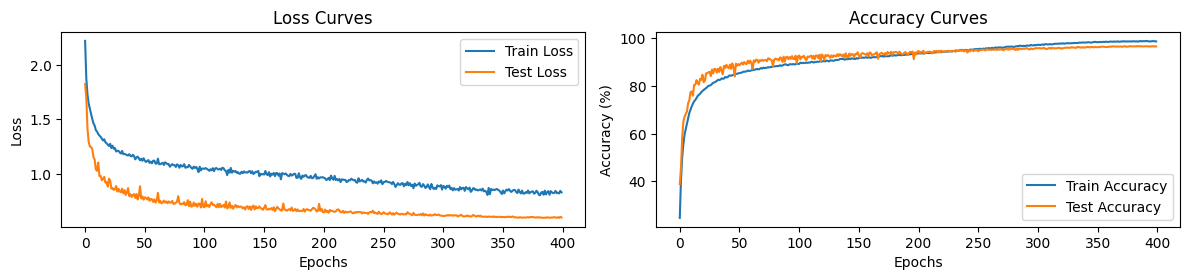

In [ ]:
# Plot training and test metrics
plt.figure(figsize=(12, 5))

plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(2, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy Curves')

plt.tight_layout()

plt.savefig('training_curves_s_mod.png')
plt.show()

In [ ]:
# Function to predict labels for test data
def predict_test_labels():
    # Load the test data from the provided file
    test_file = '/home/sr7729/Data/cifar_test_nolabel.pkl'
    with open(test_file, 'rb') as fo:
        test_data = pickle.load(fo, encoding='bytes')

    # Get data shape
    print(f"Original test data shape: {test_data[b'data'].shape}")

    # Preprocess the data
    test_images = test_data[b'data'].astype('float32') / 255.0
    # Convert from NHWC to NCHW format (PyTorch expects channels first)
    test_images = np.transpose(test_images, (0, 3, 1, 2))
    test_images_tensor = torch.from_numpy(test_images).to(device)

    # Make predictions
    model.eval()
    predictions = []
    batch_size = 100

    with torch.no_grad():
        for i in range(0, test_images_tensor.size(0), batch_size):
            batch = test_images_tensor[i:i+batch_size]
            outputs = model(batch)
            _, predicted = outputs.max(1)
            predictions.extend(predicted.cpu().numpy())

    # Create submission file
    submission = pd.DataFrame({
        'ID': range(len(predictions)),
        'Labels': predictions
    })

    submission.to_csv('submission_s_mod.csv', index=False)
    print("Submission file created successfully!")
    return submission

In [ ]:
# Create submission file
print("Creating submission file...")
submission = predict_test_labels()
submission.head()

Creating submission file...
Original test data shape: (10000, 32, 32, 3)
Submission file created successfully!


,ID,Labels
0,0,6
1,1,1
2,2,8
3,3,6
4,4,9


In [ ]:
# Print final summary
print(f"Improved ResNet Architecture Summary:")
print(f"Number of parameters: {num_params:,}")
print(f"Best train accuracy: {best_train_acc:.2f}%")
print(f"Best test accuracy: {best_acc:.2f}%")
print(f"Training time: {training_time/60:.2f} minutes")

Improved ResNet Architecture Summary:
Number of parameters: 4,903,082
Best train accuracy: 98.67%
Best test accuracy: 96.68%
Training time: 189.25 minutes


In [ ]:
def save_model(model, path="best_modell.pth"):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

# Call this function to save the model
save_model(model, path="best_resnet10_model_s_mod.pth")

Model saved to best_resnet10_model_s_mod.pth


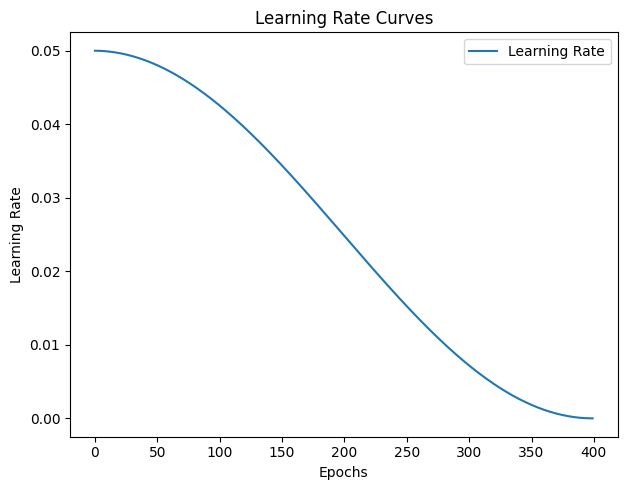

In [ ]:
# Plot training and test metrics
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(LRR, label='Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.title('Learning Rate Curves')
plt.tight_layout()

plt.savefig('training_curves_ss_mod.png')
plt.show()